# Pulsating Variable Star Accelerometer Pipeline
Measuring Accelerations From Pulsating Variable Stars MAFPVS

Measuring Accelerations Using Pulsating Variable Stars MAUPVS

Measuring Accelerations with Pulsating Stars MAPS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import minimize, curve_fit
from scipy.fft import rfft, rfftfreq, irfft
from scipy.stats import linregress
from numpy import polyfit
from astropy.modeling import models, fitting
import pickle
import pywt
import wget

In [2]:
#load in all the data and build the dictionaries
data = {}
n_splits = 6

#download the data 
#filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_V2367_Cyg.txt' #V2367_Cyg
filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_7106205.txt' #KIC 7106205

#should do splits as a uniform amount of time, not n splits per data set
with open(filename) as f:
    for i, line in enumerate(f):
        fits_file = wget.download(line.lstrip('wget --no-verbose '))
    
        hdul = fits.open(fits_file)

        splits = [] #context, this may not be required
    
        #split the data up more
        
        #define the splitting for each data period
        len_hdul = len(hdul[1].data['time'])
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]

        j = n_splits*i
        for split in splits: #there will only be 1 split if you don't need to split up that data
            
            # Read in the "BJDREF" which is the time offset of the time array.
            bjdrefi = hdul[1].header['BJDREFI']
            bjdreff = hdul[1].header['BJDREFF']

            # Read in the columns of data.
            times = hdul[1].data['time'][split]
            sap_fluxes = hdul[1].data['SAP_FLUX'][split]
            pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

            bjds = times + bjdrefi + bjdreff 

            tmp_sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
            tmp_sample_rate = 1/tmp_sample_spacing
            
            if not np.isnan(tmp_sample_spacing):
                sample_spacing = tmp_sample_spacing
            if not np.isnan(tmp_sample_rate):
                sample_rate = tmp_sample_rate

            data[j] = {
                       'bjds': bjds,
                       'sap_fluxes': sap_fluxes,
                       'pdcsap_fluxes': pdcsap_fluxes,
                       'sample_spacing': sample_spacing,
                       'sample_rate': sample_rate
                      }
            
            j += 1
    
print('data read in successfully')

100% [........................................................] 187200 / 187200data read in successfully


In [3]:
#load in all the data and build the dictionaries
data = {}
#n_splits = 6 #number of times to split each segment of data
len_segment = 165 #minimum number of stars to put in one segment
n_splits_first = 0

#download the data 
#filename = '/home/donlon/Desaktop/data/kepler_data/kepler_lc_wget_V2367_Cyg.txt' #V2367_Cyg
filename = '/home/donlon/Desktop/data/kepler_data/kepler_lc_wget_7106205.txt' #KIC 7106205

id_tracker = 0
#should do splits as a uniform amount of time, not n splits per data set
with open(filename) as f:
    for i, line in enumerate(f):
        fits_file = wget.download(line.lstrip('wget --no-verbose '))
    
        hdul = fits.open(fits_file)

        splits = [] #context, this may not be required
        
        #define the splitting for each data period
        len_hdul = len(hdul[1].data['time'])
        n_splits = int(np.floor(len_hdul/len_segment))
        if i == 0:
            n_splits_first = n_splits
        splits = [np.arange(j*len_hdul//n_splits, (j+1)*len_hdul//n_splits) for j in range(n_splits)]

        for split in splits: #there will only be 1 split if you don't need to split up that data
            
            # Read in the "BJDREF" which is the time offset of the time array.
            bjdrefi = hdul[1].header['BJDREFI']
            bjdreff = hdul[1].header['BJDREFF']

            # Read in the columns of data.
            times = hdul[1].data['time'][split]
            sap_fluxes = hdul[1].data['SAP_FLUX'][split]
            pdcsap_fluxes = hdul[1].data['PDCSAP_FLUX'][split]

            bjds = times + bjdrefi + bjdreff 

            tmp_sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
            tmp_sample_rate = 1/tmp_sample_spacing
            
            if not np.isnan(tmp_sample_spacing):
                sample_spacing = tmp_sample_spacing
            if not np.isnan(tmp_sample_rate):
                sample_rate = tmp_sample_rate

            data[id_tracker] = {
                       'bjds': bjds,
                       'sap_fluxes': sap_fluxes,
                       'pdcsap_fluxes': pdcsap_fluxes,
                       'sample_spacing': sample_spacing,
                       'sample_rate': sample_rate
                      }
            
            id_tracker += 1
    
print('data read in successfully')

100% [........................................................] 187200 / 187200data read in successfully


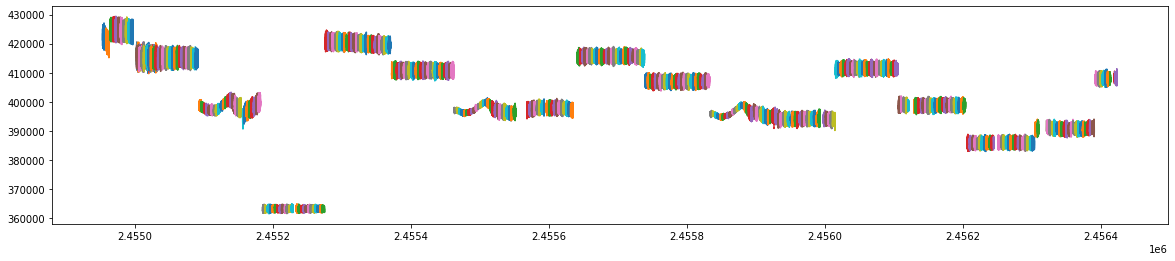

In [4]:
#all the data
fig = plt.figure(figsize=(20, 4))
for key in data.keys():
    plt.plot(data[key]['bjds'], data[key]['pdcsap_fluxes'])
plt.show()

scale of fft: 0.0005888224902672183  inverse BJDs


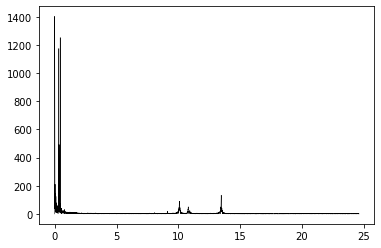

fund. freq.: 13.464573691208129 days^-1
period: 0.07426896854914636 days
scale of fft: 0.0005888224902672183  inverse BJDs


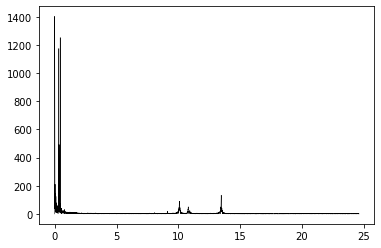

fund. freq.: 0.002491593947299802 days^-1
period: 401.3495060395869 days


In [59]:
#do a fft and find the fundamental frequency

pdcsap_fluxes = np.array([])
for i in range(500):
    pdcsap_fluxes = np.append(pdcsap_fluxes, data[i]['pdcsap_fluxes'])

#--------------------
#have to fix the fluxes first to actually get an fft
interp_pdcsap_fluxes = [(pdcsap_fluxes[i] if not(np.isnan(pdcsap_fluxes[i])) else (pdcsap_fluxes[i-1] + pdcsap_fluxes[i+1])/2 ) for i in range(len(pdcsap_fluxes))]

for j in range(100):
    interp_pdcsap_fluxes = [(interp_pdcsap_fluxes[i] if not(np.isnan(interp_pdcsap_fluxes[i])) else (interp_pdcsap_fluxes[i-j] + interp_pdcsap_fluxes[i+j])/2 ) for i in range(len(pdcsap_fluxes))]
    
i = 0
while i < len(interp_pdcsap_fluxes) and not(np.isnan(interp_pdcsap_fluxes[i])):
    i += 1
interp_pdcsap_fluxes = interp_pdcsap_fluxes[:i]
#-------------------

#compute the fft
tmp = interp_pdcsap_fluxes - np.mean(interp_pdcsap_fluxes)
power_series = rfft(tmp / np.max(tmp))
mag_power_series = np.abs(power_series)
power_series_bins = rfftfreq(len(interp_pdcsap_fluxes), sample_spacing)

delta_f = sample_rate / len(pdcsap_fluxes)
print('scale of fft:', delta_f, ' inverse BJDs')

plt.plot(power_series_bins, mag_power_series, c='k', lw=0.5)
plt.show()

#calculate the period
ffreq = power_series_bins[np.argmax(mag_power_series[1000:])+1000]
period = 1/ffreq #0.68202 #BJDs, technically a period guess
print('fund. freq.:', ffreq, 'days^-1')
print('period:', period, 'days')

#--------------------
#have to fix the fluxes first to actually get an fft
interp_pdcsap_fluxes = [(pdcsap_fluxes[i] if not(np.isnan(pdcsap_fluxes[i])) else (pdcsap_fluxes[i-1] + pdcsap_fluxes[i+1])/2 ) for i in range(len(pdcsap_fluxes))]

for j in range(100):
    interp_pdcsap_fluxes = [(interp_pdcsap_fluxes[i] if not(np.isnan(interp_pdcsap_fluxes[i])) else (interp_pdcsap_fluxes[i-j] + interp_pdcsap_fluxes[i+j])/2 ) for i in range(len(pdcsap_fluxes))]
    
i = 0
while i < len(interp_pdcsap_fluxes) and not(np.isnan(interp_pdcsap_fluxes[i])):
    i += 1
interp_pdcsap_fluxes = interp_pdcsap_fluxes[:i]
#-------------------

#compute the fft
tmp = interp_pdcsap_fluxes - np.mean(interp_pdcsap_fluxes)
power_series = rfft(tmp / np.max(tmp))
mag_power_series = np.abs(power_series)
power_series_bins = rfftfreq(len(interp_pdcsap_fluxes), sample_spacing)

delta_f = sample_rate / len(pdcsap_fluxes)
print('scale of fft:', delta_f, ' inverse BJDs')

plt.plot(power_series_bins, mag_power_series, c='k', lw=0.5)
plt.show()

#calculate the period
ffreq = power_series_bins[np.argmax(mag_power_series)]
period = 1/ffreq #0.68202 #BJDs, technically a period guess
print('fund. freq.:', ffreq, 'days^-1')
print('period:', period, 'days')

In [37]:
period = 0.07416 #0.009268 #hard coded for this particular star

scan_width = 0.0000001
scan_n = 5e2
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

/tmp/ipykernel_7981/3821111956.py:12: RuntimeWarning: Mean of empty slice
  mean_time = np.nanmean(data['bjds'])
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/3821111956.py:53: RuntimeWarning: invalid value encountered in double_scalars
  like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty


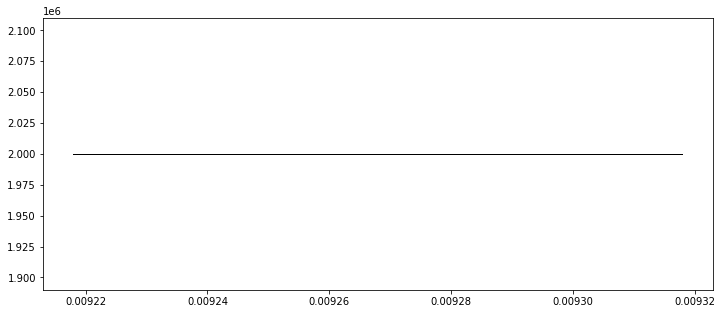

/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


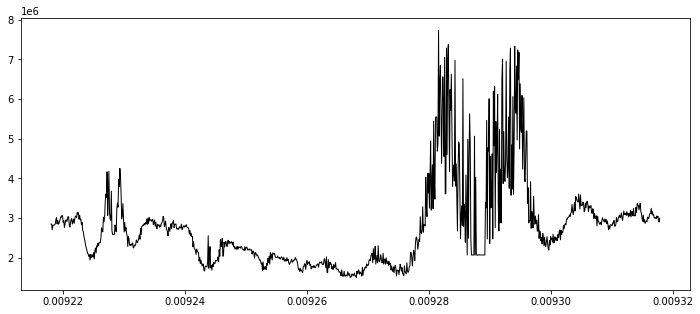

/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


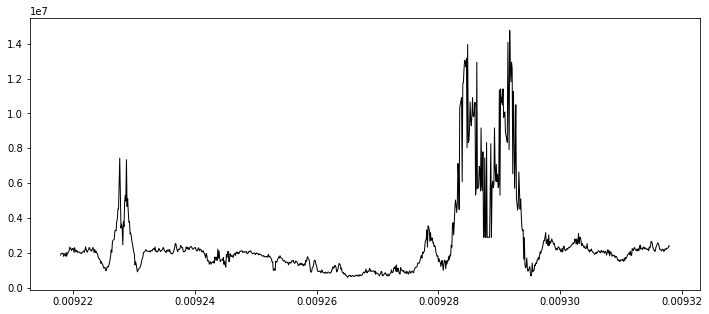

/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


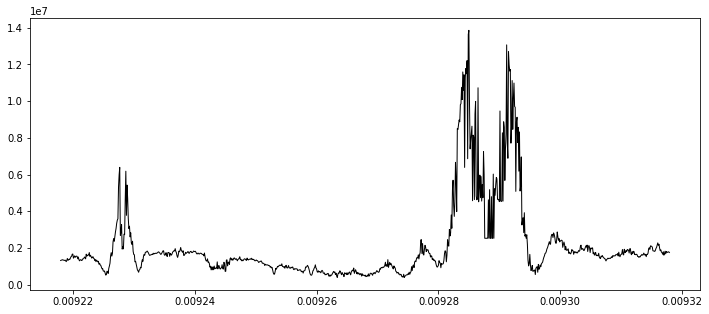

/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/donlon/.local/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


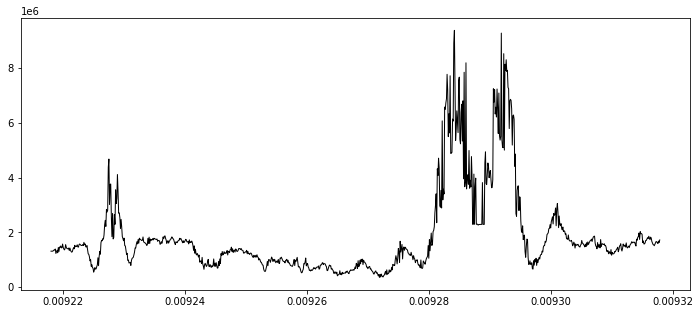

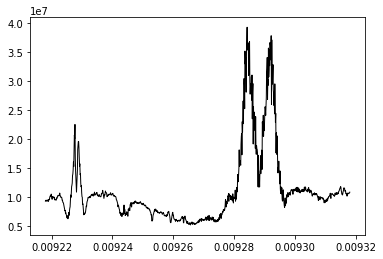

In [6]:
all_likes_sum = np.array([])

for key in [600, 601, 602, 603, 604]:

    #the optimizer
    def likelihood(period, data, verbose_out=False):

        #fold the data based on the period
        folded_bjds = (data['bjds']/period) - (data['bjds']/period).astype(int)
        fixed_fluxes = data['pdcsap_fluxes']

        mean_time = np.nanmean(data['bjds'])

        #bin the data
        bin_width = 0.05
        binned_pdcsap_fluxes = []
        binned_bjds = []
        binned_times = []

        i = 0
        while i < 1:
            indx = (folded_bjds >= i)*(folded_bjds < i+bin_width)
            binned_pdcsap_fluxes.append(fixed_fluxes[indx])
            binned_bjds.append(folded_bjds[indx])
            binned_times.append(data['bjds'][indx])
            i += bin_width

        #compute the dispersion of each bin w.r.t. a linear fit:    
        #then adjust the data according to that linear fit
        slope_adj_fluxes = []
        lfs = []
        mean_times = []
        for i in range(len(binned_bjds)):
            indx = (np.logical_not(np.isnan(binned_bjds[i])))*(np.logical_not(np.isnan(binned_pdcsap_fluxes[i])))
            if len(binned_pdcsap_fluxes[i][indx]) == 0:
                slope_adj_fluxes.append([np.nan, np.nan, np.nan])
                mean_times.append(np.nan)
            else:
                lf = linregress(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
                lfs.append(lf)
                slope_adj_fluxes.append([binned_pdcsap_fluxes[i][indx][j] - (lf[0]*binned_bjds[i][indx][j] + lf[1]) for j in range(len(binned_pdcsap_fluxes[i][indx]))])
                mean_times.append(np.nanmean(binned_times[i][indx]))

        mean_times = np.array(mean_times)
        disps = np.array([np.nanstd(f) for f in slope_adj_fluxes])
        for i in range(len(disps)):
            if len(binned_pdcsap_fluxes[i]) == 0:
                disps[i] = np.nan

        #likelihood score is just the sum of all dispersions
        penalty = 1e5 #penalize not having anything in a bin
        weight = 5e5 #how much to weight the time differences compared to the variances
        like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty
        like += np.nansum((mean_times - mean_time)**2)*weight
        
#         if not(np.isnan(like)):
#             plt.scatter(folded_bjds, fixed_fluxes, c=data['bjds'], s=5)
#             plt.show()
#             print(np.nansum((mean_times - mean_time)**2)*weight)

#         print(mean_times)
#         print(mean_times - mean_time)
#         print(np.nansum((mean_times - mean_time)**2)*weight)
#         print(like)
        
        if np.isnan(like):
            return penalty*len(disps)

        if verbose_out:
            return like, disps, lfs
        else:
            return like


    #brute force bc the likelihood surface isn't actually differentiable
    #now with threading
    def scan_time_slices(data):

        all_likes = []

        best_period = period
        best_like = likelihood(period, data[key])

        for p in times:
            like = likelihood(p, data[key])
            all_likes.append(like)
            if like < best_like:
                best_period = p
                best_like = like

        return best_period, all_likes

    #optimize the period of each time slice
    best_periods, all_likes = scan_time_slices(data)
    fig = plt.figure(figsize=(12,5))
    plt.plot(times, all_likes, c='k', lw=1)
    plt.show()
    
    if len(all_likes_sum) == 0:
        all_likes_sum = np.array(all_likes)
    else:
        all_likes_sum += all_likes

plt.plot(times, all_likes_sum, c='k', lw=1)
plt.show()

In [13]:
def wavelet_denoising(x, wavelet='db4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

/tmp/ipykernel_7981/148051655.py:2: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % tp)/tp


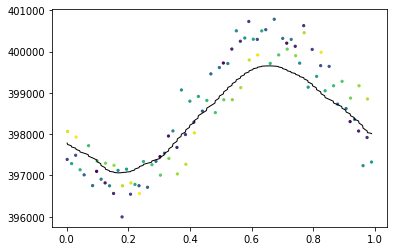

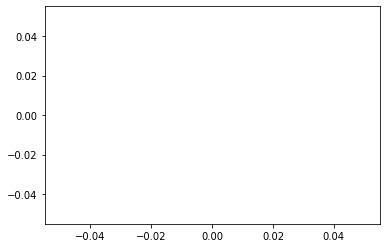

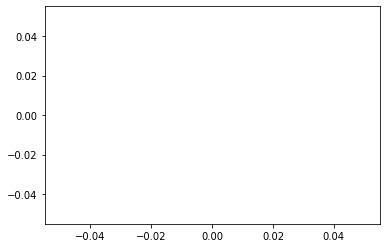

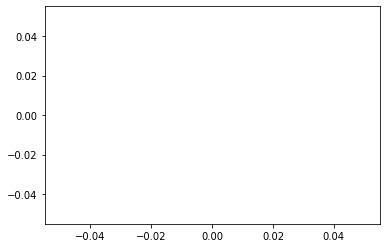

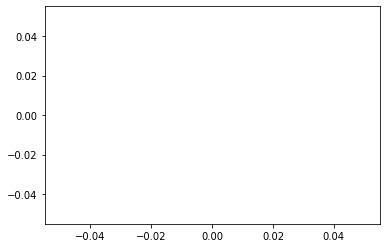

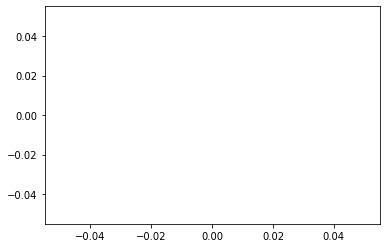

nan
1534632.6554710355


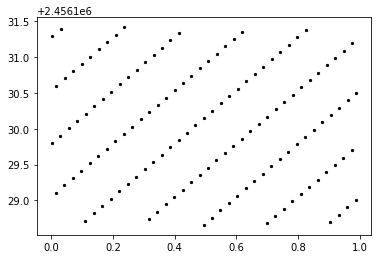

11.981174562662146


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/2867600311.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))


In [14]:
tp = 0.009265
folded_bjds = (data[key]['bjds'] % tp)/tp
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

y = wavelet_denoising(fixed_fluxes_sorted)

plt.scatter(folded_bjds, fixed_fluxes, c=data[key]['bjds'], s=5)
plt.plot(sorted(folded_bjds), y, c='k', lw=1)
plt.show()

#bin the data
n_time_bins = 5
binned_times = []
binned_folded_bjds = []
binned_fluxes = []
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
while i < n_time_bins:
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_times.append(centered_times[indx])
    binned_folded_bjds.append(folded_bjds[indx])
    binned_fluxes.append(fixed_fluxes[indx])
    i += 1

for i, b in enumerate(binned_times):
    plt.scatter(binned_folded_bjds[i], binned_fluxes[i], c='k', s=5)
    plt.show()
    
#calculate mean squared distance between each consecutive pair of folded bjds
mean_dist = np.mean((folded_bjds[1:] - folded_bjds[:-1])**2)
print(mean_dist)
mean_dist = np.std((np.array(fixed_fluxes_sorted)[1:] - np.array(fixed_fluxes_sorted)[:-1])**2)
print(mean_dist)
    
plt.scatter(folded_bjds, data[key]['bjds'], c='k', s=5)
plt.show()

print(likelihood(tp, data[key]))

/tmp/ipykernel_7981/911961887.py:2: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (data[key]['bjds'] % tp)/tp


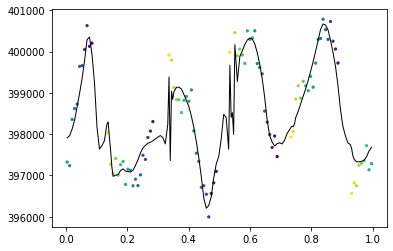

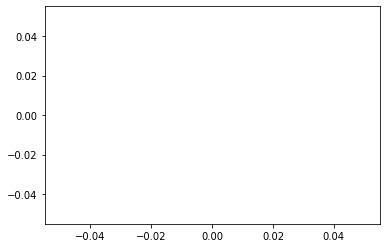

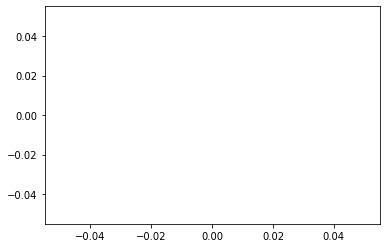

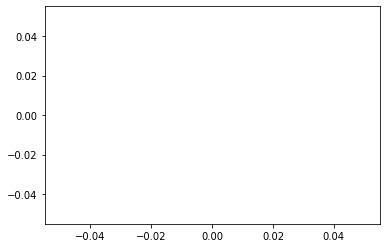

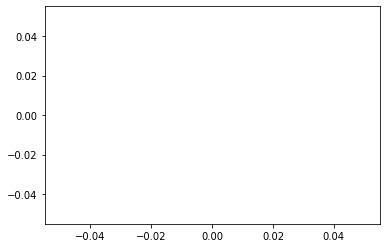

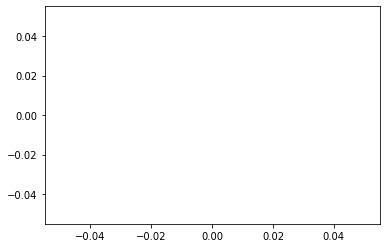

nan
942554.4374208126
11.621026117871882


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/2867600311.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))


In [15]:
tp = 0.009295
folded_bjds = (data[key]['bjds'] % tp)/tp
fixed_fluxes = data[key]['pdcsap_fluxes']
fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]

y = wavelet_denoising(fixed_fluxes_sorted)

plt.scatter(folded_bjds, fixed_fluxes, c=data[key]['bjds'], s=5)
plt.plot(sorted(folded_bjds), y, c='k', lw=1)
plt.show()

#bin the data
n_time_bins = 5
binned_times = []
binned_folded_bjds = []
binned_fluxes = []
bin_width = (np.max(data[key]['bjds']) - np.min(data[key]['bjds']))/n_time_bins
centered_times = data[key]['bjds'] - np.min(data[key]['bjds'])

i = 0
while i < n_time_bins:
    indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
    binned_times.append(centered_times[indx])
    binned_folded_bjds.append(folded_bjds[indx])
    binned_fluxes.append(fixed_fluxes[indx])
    i += 1

for i, b in enumerate(binned_times):
    plt.scatter(binned_folded_bjds[i], binned_fluxes[i], c='k', s=5)
    plt.show()

#calculate mean squared distance between each consecutive pair of folded bjds
mean_dist = np.mean((folded_bjds[1:] - folded_bjds[:-1])**2)
print(mean_dist)
mean_dist = np.std((np.array(fixed_fluxes_sorted)[1:] - np.array(fixed_fluxes_sorted)[:-1])**2)
print(mean_dist)

# plt.scatter(folded_bjds, data[key]['bjds'], c='k', s=5)
# plt.show()

print(likelihood(tp, data[key]))

In [16]:
period = 0.009268 #hard coded for this particular star

scan_width = 0.00000001
scan_n = 1e3
times = np.arange(period-scan_n*scan_width, period+scan_n*scan_width, scan_width)

/tmp/ipykernel_168373/719822275.py:74: RuntimeWarning: invalid value encountered in double_scalars
  like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty


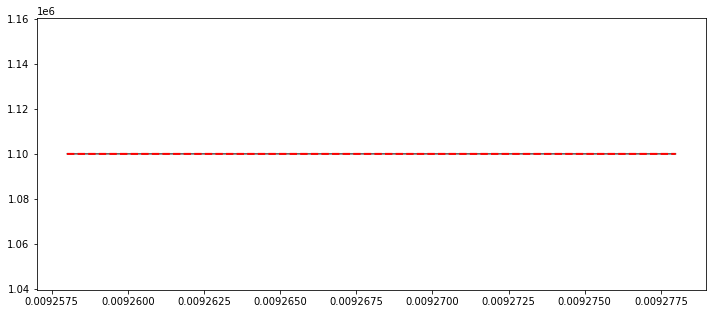

period: 0.009266932815500561
variance: 0.25131030779858327


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


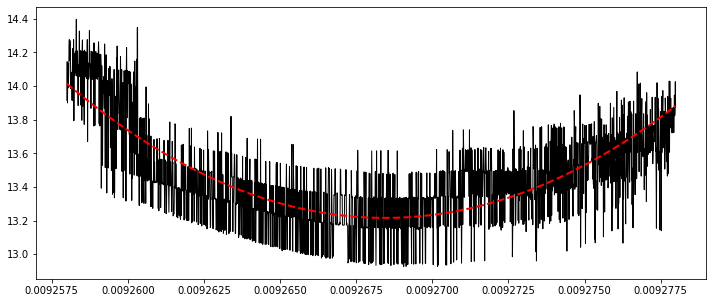

period: 0.009268446870193047
variance: 6.839350624311181e-11


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

In [317]:
all_likes_sum = np.array([])

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

#numerical 2nd derivative at indx, with step size dindx (in indices)
def der2(x, y, indx, dindx):
    
    left = y[indx - dindx]
    center = y[indx]
    right = y[indx + dindx]
    
    dt = np.abs(x[0] - x[dindx]) #assuming uniform step size
    
    return (left + right - 2*center)/dt**2

for key in [600, 601, 602, 603, 604, 605, 606, 607, 608, 609]:

    #the optimizer
    def likelihood(period, data, verbose_out=False):

        #fold the data based on the period
        folded_bjds = (data['bjds']/period) - (data['bjds']/period).astype(int)
        fixed_fluxes = data['pdcsap_fluxes']

        #bin the data
        bin_width = 0.1
        binned_pdcsap_fluxes = []
        binned_bjds = []

        i = 0
        while i < 1:
            indx = (folded_bjds >= i)*(folded_bjds < i+bin_width)
            binned_pdcsap_fluxes.append(fixed_fluxes[indx])
            binned_bjds.append(folded_bjds[indx])
            i += bin_width

        #compute the dispersion of each bin w.r.t. a linear fit:    
        #then adjust the data according to that linear fit
        slope_adj_fluxes = []
        lfs = []
        mean_times = []
        for i in range(len(binned_bjds)):
            indx = (np.logical_not(np.isnan(binned_bjds[i])))*(np.logical_not(np.isnan(binned_pdcsap_fluxes[i])))
            if len(binned_pdcsap_fluxes[i][indx]) == 0:
                slope_adj_fluxes.append([np.nan, np.nan, np.nan])
            else:
                lf = linregress(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
                lfs.append(lf)
                slope_adj_fluxes.append([binned_pdcsap_fluxes[i][indx][j] - (lf[0]*binned_bjds[i][indx][j] + lf[1]) for j in range(len(binned_pdcsap_fluxes[i][indx]))])

        disps = np.array([np.nanstd(f) for f in slope_adj_fluxes])
        for i in range(len(disps)):
            if len(binned_pdcsap_fluxes[i]) == 0:
                disps[i] = np.nan
                
        #compute number of maxima in folded data
        fixed_fluxes_sorted = [x for _, x in sorted(zip(folded_bjds, fixed_fluxes))]
        fixed_fluxes_sorted = [x if not np.isnan(x) else 398000 for x in fixed_fluxes_sorted]
        y = wavelet_denoising(fixed_fluxes_sorted)
        n_max = len(argrelextrema(y, np.greater)[0])

        #likelihood score is just the sum of all dispersions
        penalty = 1e5 #penalize not having anything in a bin
        weight = 1e5 #how much to weight the time differences compared to the variances
        like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty
        like = like + n_max*weight
        
#         if not(np.isnan(like)):
#             plt.scatter(folded_bjds, fixed_fluxes, c=data['bjds'], s=5)
#             plt.show()
#             print(np.nansum((mean_times - mean_time)**2)*weight)

#         print(mean_times)
#         print(mean_times - mean_time)
#         print(np.nansum((mean_times - mean_time)**2)*weight)
#         print(like)

#         print(n_max)
#         print(n_max*weight)
#         print(like)
        
        if np.isnan(like):
            return penalty*len(disps)

        if verbose_out:
            return np.log(like), disps, lfs
        else:
            return np.log(like)


    #brute force bc the likelihood surface isn't actually differentiable
    #now with threading
    def scan_time_slices(data):

        all_likes = []

        best_period = period
        best_like = likelihood(period, data[key])

        for p in times:
            like = likelihood(p, data[key])
            all_likes.append(like)
            if like < best_like:
                best_period = p
                best_like = like

        return best_period, all_likes
    
    def func(params, datax):
        return params[0]*datax**2 + params[1]*datax + params[2]
    
    def rss(params, datax, datay):
        resid = np.sum((datay - func(params, datax))**2)/(len(datax - 3)) #reduced chi squared
        return resid
    
    def OLS_uncertainty(datax, params, resid):
    
        #scale the data so min=-1, max=1, mean=0
        scaled_dx = datax - np.mean(datax)
        scaled_dx /= np.max(scaled_dx)

        xmat = np.array([[i**2, i, 1] for i in scaled_dx])
        cov = np.linalg.inv(np.matmul(xmat.T, xmat))

        return np.sqrt(resid*np.diag(cov))

    #optimize the period of each time slice
    best_periods, all_likes = scan_time_slices(data)
    fig = plt.figure(figsize=(12,5))
    
#     pf = np.polyfit(times, all_likes, 2)
#     plt.plot(times, all_likes, c='k', lw=1)
#     plt.plot(times, pf[0]*times**2 + pf[1]*times + pf[2], c='r', lw=1)
#     plt.show()
    
#     print('variance:', 1/(2*pf[0]))

    pf = np.polyfit(times, all_likes, 2) #probably horribly inefficient but whatever
    result = minimize(rss, pf, args=(times, all_likes), method='Nelder-Mead')
    popt = result.x
    resid = result.fun

    plt.plot(times, all_likes, c='k', lw=1)
    plt.plot(times, popt[0]*times**2 + popt[1]*times + popt[2], c='r', lw=2, ls='--')
    plt.show()
    
    #period and uncertainty calculations
    fit_period = -popt[1]/(2*popt[0])
    mle_unc = 1/(2*popt[0])
    punc = OLS_uncertainty(times, popt, resid)
    best_fit_unc = ((1/(4*popt[0]**2))*((popt[1]/popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
    variance = (best_fit_unc**2 + mle_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    print('period:', fit_period)
    print('variance:', variance)
    
    if len(all_likes_sum) == 0:
        all_likes_sum = np.array(all_likes)
    else:
        all_likes_sum += all_likes

fig = plt.figure(figsize=(12,5))
plt.plot(times, all_likes_sum, c='k', lw=1)
plt.show()

/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))
/tmp/ipykernel_7981/96425851.py:85: RuntimeWarning: invalid value encountered in double_scalars
  like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty + kld_scale*mean_kld


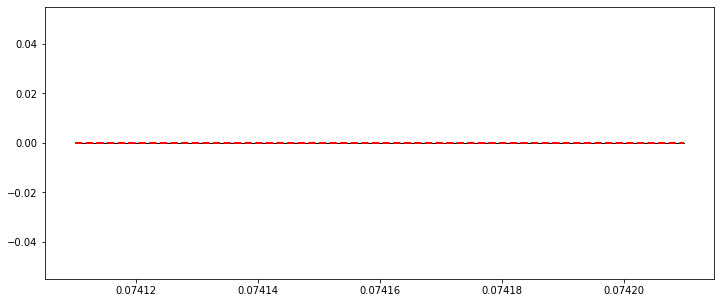

/tmp/ipykernel_7981/96425851.py:167: RuntimeWarning: invalid value encountered in double_scalars
  fit_period = -popt[1]/(2*popt[0])
/tmp/ipykernel_7981/96425851.py:168: RuntimeWarning: divide by zero encountered in double_scalars
  mle_unc = 1/(2*popt[0])
/tmp/ipykernel_7981/96425851.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  best_fit_unc = ((1/(4*popt[0]**2))*((popt[1]/popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
/tmp/ipykernel_7981/96425851.py:170: RuntimeWarning: invalid value encountered in double_scalars
  best_fit_unc = ((1/(4*popt[0]**2))*((popt[1]/popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))


period: nan
variance: nan


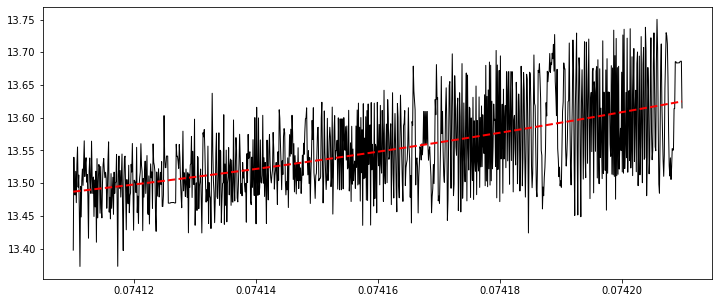

period: 0.07394335759487379
variance: 1.568883920864817e-07


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: divide by zero encountered in log
  kld = h * np.log(h/np.mean(h))
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in multiply
  kld = h * np.log(h/np.mean(h))


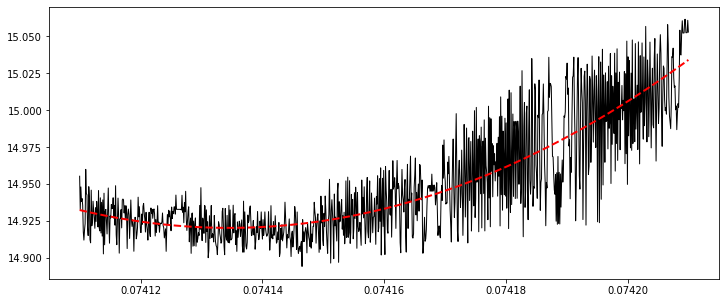

period: 0.07413456359976356
variance: 2.497686720176345e-08


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))


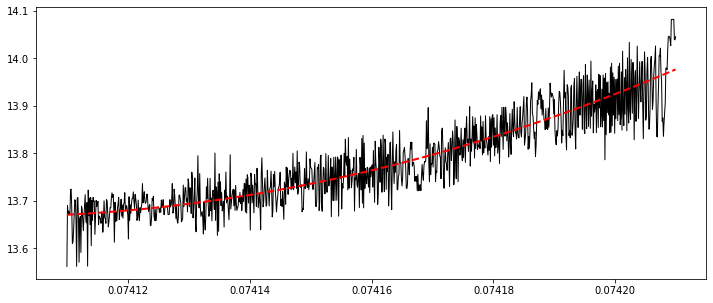

period: 0.07409600174152112
variance: 2.090955185078829e-08


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in true_divide
  kld = h * np.log(h/np.mean(h))


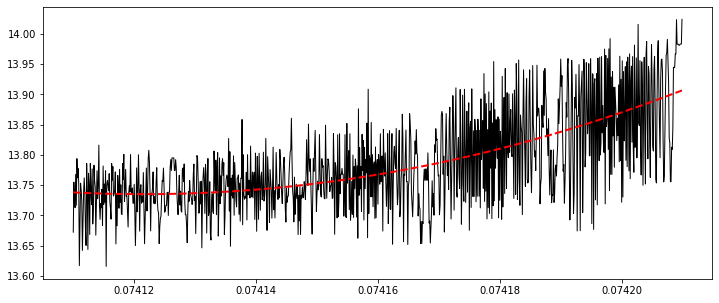

period: 0.0741214988224552
variance: 2.2807856294012913e-08


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: divide by zero encountered in log
  kld = h * np.log(h/np.mean(h))
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in multiply
  kld = h * np.log(h/np.mean(h))


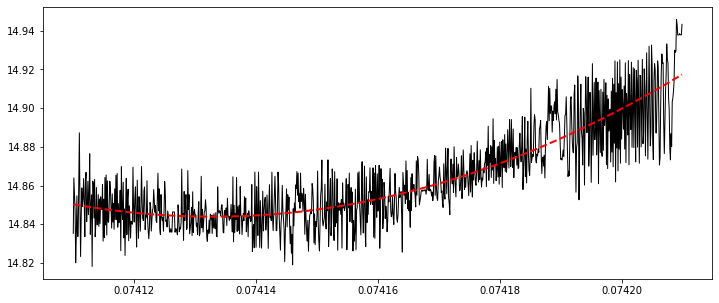

period: 0.07413280426397471
variance: 4.04775622290331e-08


/home/donlon/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: divide by zero encountered in log
  kld = h * np.log(h/np.mean(h))
/tmp/ipykernel_7981/96425851.py:10: RuntimeWarning: invalid value encountered in multiply
  kld = h * np.log(h/np.mean(h))


KeyboardInterrupt: 

In [38]:
all_likes_sum = np.array([])

#kld settings
n_time_bins = 10 #how many time bins to split up time segments (~5 seems to work well)
n_kld_bins = 50 #how many bins are used to compute KLD (sensitive to choice, not really a true numerical integral)
kld_scale = 1e5 #how much to weight the kld value (should probably be a fractional amount rather than scalar multiple)

def kld(arr):
    h = np.histogram(arr, bins=n_kld_bins)[0]
    kld = h * np.log(h/np.mean(h))
    return np.nansum(kld)

def wavelet_denoising(x, wavelet='db4', level=1): #db4 #coif8
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

#numerical 2nd derivative at indx, with step size dindx (in indices)
def der2(x, y, indx, dindx):
    
    left = y[indx - dindx]
    center = y[indx]
    right = y[indx + dindx]
    
    dt = np.abs(x[0] - x[dindx]) #assuming uniform step size
    
    return (left + right - 2*center)/dt**2

for key in [600, 601, 602, 603, 604, 605, 606, 607, 608, 609]:

    #the optimizer
    def likelihood(period, data, verbose_out=False):

        #fold the data based on the period
        folded_bjds = (data['bjds']/period) - (data['bjds']/period).astype(int)
        fixed_fluxes = data['pdcsap_fluxes']

        #bin the data
        bin_width = 0.1
        binned_pdcsap_fluxes = []
        binned_bjds = []

        i = 0
        while i < 1:
            indx = (folded_bjds >= i)*(folded_bjds < i+bin_width)
            binned_pdcsap_fluxes.append(fixed_fluxes[indx])
            binned_bjds.append(folded_bjds[indx])
            i += bin_width

        #compute the dispersion of each bin w.r.t. a linear fit:    
        #then adjust the data according to that linear fit
        slope_adj_fluxes = []
        lfs = []
        mean_times = []
        for i in range(len(binned_bjds)):
            indx = (np.logical_not(np.isnan(binned_bjds[i])))*(np.logical_not(np.isnan(binned_pdcsap_fluxes[i])))
            if len(binned_pdcsap_fluxes[i][indx]) == 0:
                slope_adj_fluxes.append([np.nan, np.nan, np.nan])
            else:
                lf = linregress(binned_bjds[i][indx], binned_pdcsap_fluxes[i][indx])
                lfs.append(lf)
                slope_adj_fluxes.append([binned_pdcsap_fluxes[i][indx][j] - (lf[0]*binned_bjds[i][indx][j] + lf[1]) for j in range(len(binned_pdcsap_fluxes[i][indx]))])

        disps = np.array([np.nanstd(f) for f in slope_adj_fluxes])
        for i in range(len(disps)):
            if len(binned_pdcsap_fluxes[i]) == 0:
                disps[i] = np.nan
        
        #compute the KLD of the binned folded times 
        #bin the data
        bin_width = (np.max(data['bjds']) - np.min(data['bjds']))/n_time_bins
        centered_times = data['bjds'] - np.min(data['bjds'])
        mean_kld = 0
        for i in range(n_time_bins):
            indx = (centered_times >= i*bin_width)*(centered_times < (i+1)*bin_width)
            mean_kld += kld(folded_bjds[indx])
        mean_kld /= n_time_bins
#         if mean_kld != 0:
#             print('mean kld', mean_kld)

        #likelihood score is just the sum of all dispersions + scaled KLD of binned folded bjds
        penalty = 0 #penalize not having anything in a bin
        like = np.nansum(disps**2)/len(disps[np.logical_not(np.isnan(disps))]) + len(disps[np.isnan(disps)])*penalty + kld_scale*mean_kld
        
#         if not(np.isnan(like)):
#             plt.scatter(folded_bjds, fixed_fluxes, c=data['bjds'], s=5)
#             plt.show()
#             print(np.nansum((mean_times - mean_time)**2)*weight)

#         print(mean_times)
#         print(mean_times - mean_time)
#         print(np.nansum((mean_times - mean_time)**2)*weight)
#         print(like)

#         print(n_max)
#         print(n_max*weight)
#         print(like)
        
        if np.isnan(like):
            return penalty*len(disps)

        if verbose_out:
            return np.log(like), disps, lfs
        else:
            return np.log(like)


    #brute force bc the likelihood surface isn't actually differentiable
    #now with threading
    def scan_time_slices(data):

        all_likes = []

        best_period = period
        best_like = likelihood(period, data[key])

        for p in times:
            like = likelihood(p, data[key])
            all_likes.append(like)
            if like < best_like:
                best_period = p
                best_like = like

        return best_period, all_likes
    
    def func(params, datax):
        return params[0]*datax**2 + params[1]*datax + params[2]
    
    def rss(params, datax, datay):
        resid = np.sum((datay - func(params, datax))**2)/(len(datax - 3)) #reduced chi squared
        return resid
    
    def OLS_uncertainty(datax, params, resid):
    
        #scale the data so min=-1, max=1, mean=0
        scaled_dx = datax - np.mean(datax)
        scaled_dx /= np.max(scaled_dx)

        xmat = np.array([[i**2, i, 1] for i in scaled_dx])
        cov = np.linalg.inv(np.matmul(xmat.T, xmat))

        return np.sqrt(resid*np.diag(cov))

    #optimize the period of each time slice
    best_periods, all_likes = scan_time_slices(data)
    fig = plt.figure(figsize=(12,5))
    
#     pf = np.polyfit(times, all_likes, 2)
#     plt.plot(times, all_likes, c='k', lw=1)
#     plt.plot(times, pf[0]*times**2 + pf[1]*times + pf[2], c='r', lw=1)
#     plt.show()
    
#     print('variance:', 1/(2*pf[0]))

    pf = np.polyfit(times, all_likes, 2) #probably horribly inefficient but whatever
    result = minimize(rss, pf, args=(times, all_likes), method='Nelder-Mead')
    popt = result.x
    resid = result.fun

    plt.plot(times, all_likes, c='k', lw=1)
    plt.plot(times, popt[0]*times**2 + popt[1]*times + popt[2], c='r', lw=2, ls='--')
    plt.show()
    
    #period and uncertainty calculations
    fit_period = -popt[1]/(2*popt[0])
    mle_unc = 1/(2*popt[0])
    punc = OLS_uncertainty(times, popt, resid)
    best_fit_unc = ((1/(4*popt[0]**2))*((popt[1]/popt[0])**2 * punc[0]**2 + punc[1]**2))**0.5
    variance = (best_fit_unc**2 + mle_unc**2)**0.5 #idk what else to do but add them in quadrature
    
    print('period:', fit_period)
    print('variance:', variance)
    
    if len(all_likes_sum) == 0:
        all_likes_sum = np.array(all_likes).astype(float)
    else:
#         print(type(all_likes_sum))
#         print(type(np.array(all_likes)))
        all_likes_sum += np.array(all_likes)

fig = plt.figure(figsize=(12,5))
plt.plot(times, all_likes_sum, c='k', lw=1)
plt.show()